In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)

In [5]:
df=pd.read_csv("bengaluru_house_prices.csv")
df.head()
df.isna().sum()
df3 = df.drop(['area_type','society','balcony','availability'],axis=1)

In [6]:
df3.dropna(inplace=True)
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [7]:
df3['bhk']=df3['size'].apply(lambda x : int(x.split()[0]))
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
bhk           0
dtype: int64

In [8]:
df3['total_sqft'].unique()
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True


In [9]:
def sqft_to_float(x):
    split= x.split('-')
    if len(split) == 2:
        return (float(split[0])+float(split[1]))/2.0
    try:
        return float(x)
                
    except:
        return None


df3.total_sqft = df3.total_sqft.apply(sqft_to_float)
df3 = df3[df3.total_sqft.notnull()]
df3.total_sqft.unique()

array([1056. , 2600. , 1440. , ..., 1258.5,  774. , 4689. ])

In [10]:
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
bhk           0
dtype: int64

In [11]:
df3.iloc[-3,2]

1141.0

In [12]:
np.array(df3['total_sqft'])
for i in range(-3,-5,-1):
    print(type(i))

<class 'int'>
<class 'int'>


In [13]:
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


# Feature Engineering
 Adding a new feature price per sqft
 

In [14]:
df4=df3.copy()
df4['price_per_sqft'] = df3['price']*100000/df3['total_sqft']

len(df4['location'].unique())



1298

In [15]:
df4.location = df4.location.apply(lambda x: x.strip())
stats_location=df4['location'].value_counts(ascending=False)
print(stats_location.sum())
less_than_11=stats_location[stats_location<=10]
print(stats_location[stats_location>10])

13200
Whitefield            533
Sarjapur  Road        392
Electronic City       304
Kanakpura Road        264
Thanisandra           235
                     ... 
Doddaballapur          11
Marsur                 11
Kodigehalli            11
Banjara Layout         11
Pattandur Agrahara     11
Name: location, Length: 240, dtype: int64


In [16]:
len(stats_location)
#len(less_than_11)


1287

tuning loacation category 


In [17]:
df4.location = df4.location.apply(lambda x: 'other' if x in less_than_11 else x)
len(df4.location.unique())

241

In [18]:
df4.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


# Outlier removing buiseness logic
**As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft**

In [19]:
df4[df4.total_sqft/df4.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [20]:
df6 = df4[~(df4.total_sqft/df4.bhk<300)]
df6.shape

(12456, 7)

<h2> Outlier Removal Using Standard Deviation and Mean</h2>

In [21]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

**Now to remove outliers from price_per_sqft we will use 68-95-99.7 rule , we will remove all those price_per_sqft rows which are below and above 1 STD from mean**


In [22]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key,subdf in df.groupby('location'):
        m=np.mean(subdf['price_per_sqft'])
        std = np.std(subdf['price_per_sqft'])
        reduced_df = subdf[(subdf.price_per_sqft>(m-std)) & (subdf.price_per_sqft<=(m+std))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7=remove_pps_outliers(df6)


In [23]:
df7.shape

(10242, 7)

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

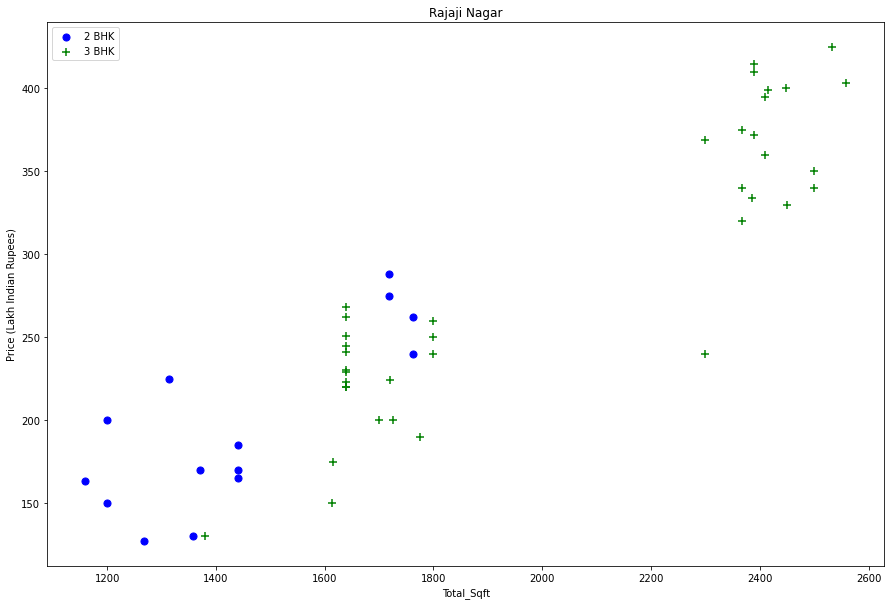

In [24]:
def plot_scatter(df,location):
    bhk2=df[(df['location']==location) & (df.bhk==2)]
    bhk3=df[(df['location']==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+',color='green',label='3 BHK',s=50)
    plt.xlabel("Total_Sqft")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    plt.show()
plot_scatter(df7,"Rajaji Nagar")


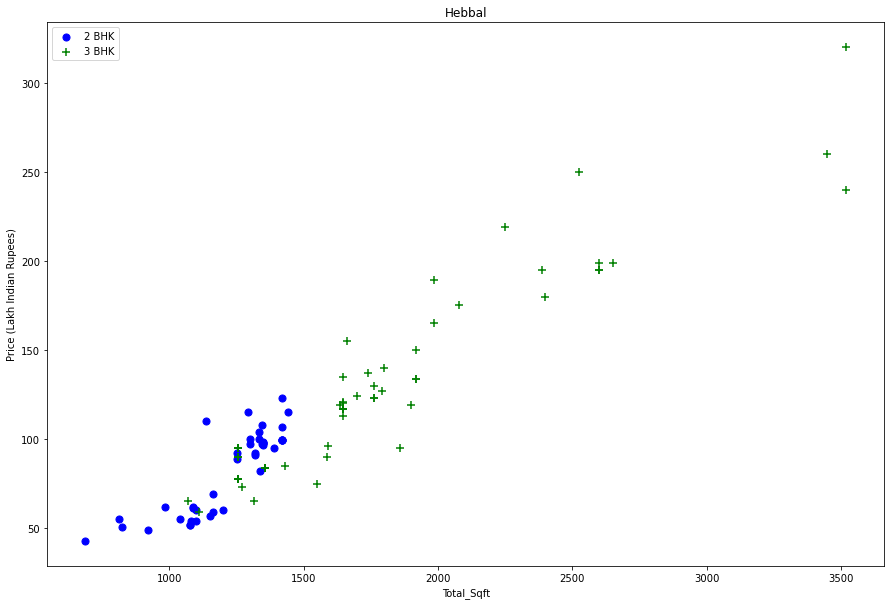

In [25]:
plot_scatter(df7,"Hebbal")

**We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.**


In [26]:
{
    1:{
        'mean' : 4000,
        'std' : 2000,
        'count':34,
    },
    2:{
        'mean' : 4300,
        'std' : 2300,
        'count':22
    }
}


{1: {'mean': 4000, 'std': 2000, 'count': 34},
 2: {'mean': 4300, 'std': 2300, 'count': 22}}

In [27]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location,location_df in df.groupby('location'):
        bhk_stats={}
        for bhk,bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk]={
                'mean':np.mean(bhk_df.price_per_sqft),
                'std' : np.std(bhk_df.price_per_sqft),
                'count' : bhk_df.shape[0]
            }
        for bhk,bhk_df in location_df.groupby('bhk'):
            stats=bhk_stats.get(bhk-1)
            if stats  and stats['count']>5:
                exclude_indices=np.append(exclude_indices,bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

df8=remove_bhk_outliers(df7)
df8.shape            

(7317, 7)

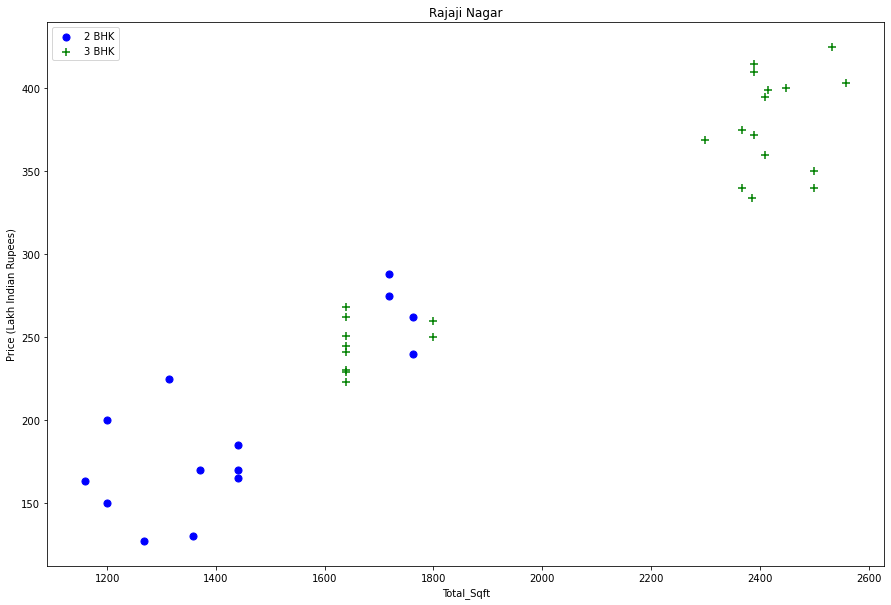

In [28]:
plot_scatter(df8,"Rajaji Nagar")

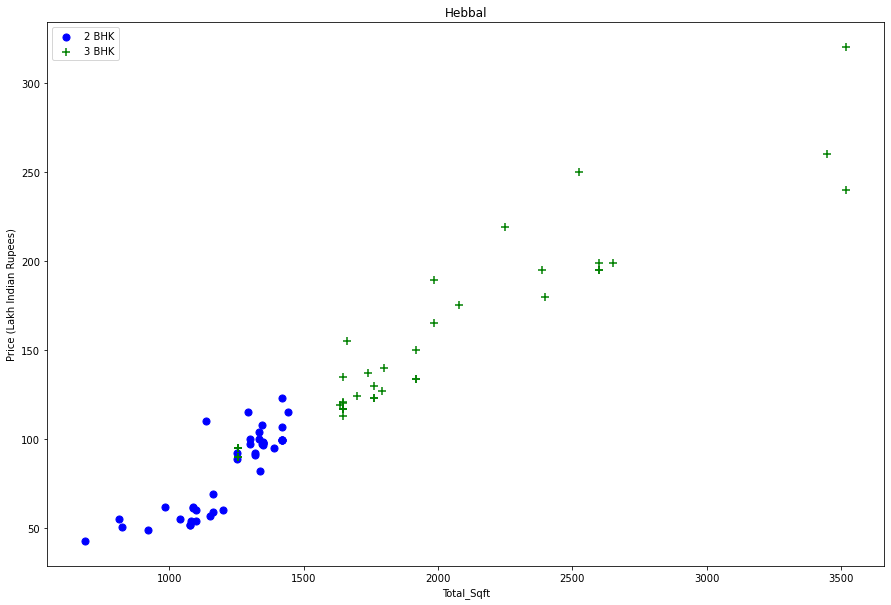

In [29]:
plot_scatter(df8,"Hebbal")

Text(0, 0.5, 'Count')

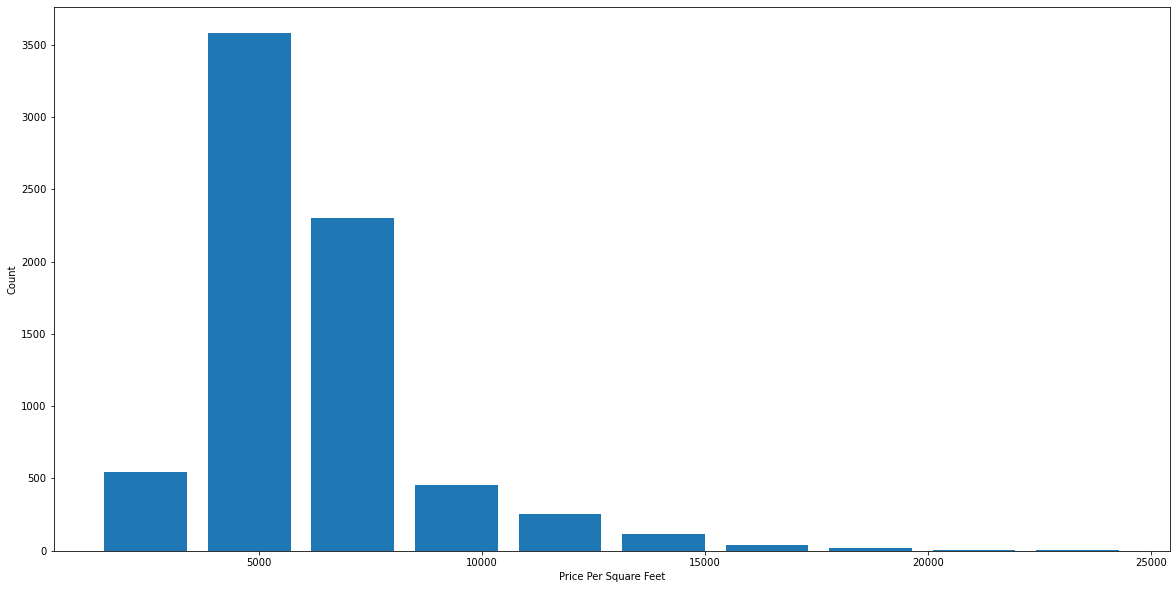

In [30]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

<h2 style='color:blue'>Outlier Removal Using Bathrooms Feature</h2>

Text(0, 0.5, 'Count')

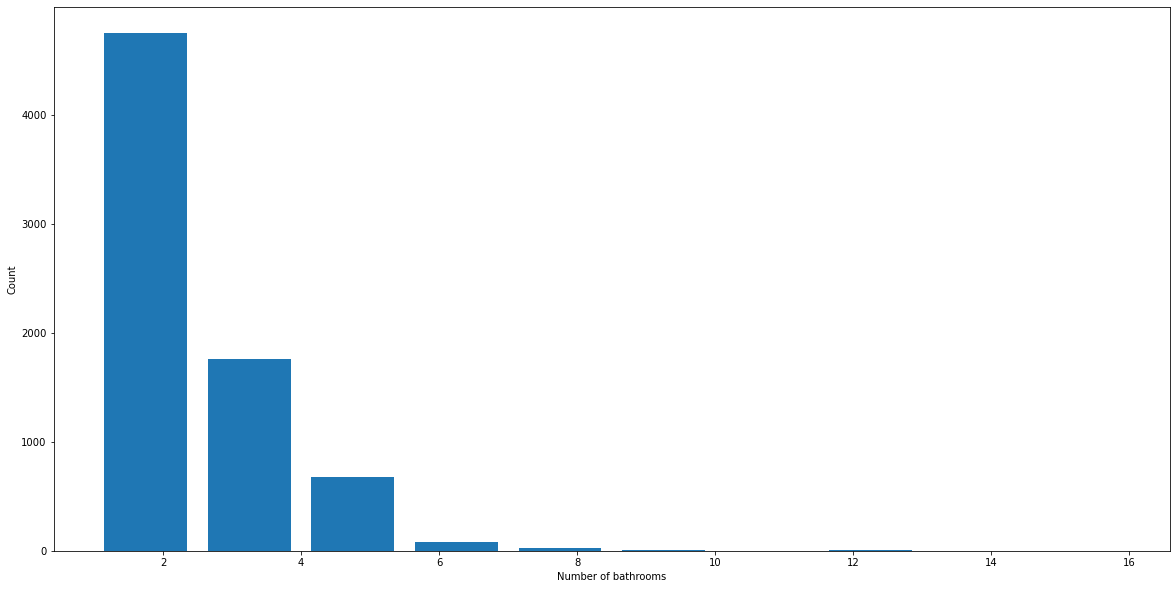

In [31]:
df8.bath.unique()
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

**Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed**

In [32]:
df9=df8[df8.bath <df8.bhk +2]


Now just dropping the extra columns

In [33]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.shape
#our data is finally filtered completelty

(7239, 5)

<h2 style='color:blue'>Use One Hot Encoding For Location</h2>

In [34]:
dummies=pd.get_dummies(df10.location)
df11=pd.concat([df10,dummies.drop('other',axis=1)],axis=1) 
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
df12 = df11.drop('location',axis='columns')
df12.shape

(7239, 244)

**Building a Model Now**

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
y=df12['price']
X = df12.drop('price',axis=1)
print(X.shape)
print(y.shape)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,ran)
model=LinearRegression()
model.fit(X_train,y_train)
model.score(X_test,y_test)


(7239, 243)
(7239,)


0.788998490417887

<h2 style='color:blue'>Use K Fold cross validation to measure accuracy of our LinearRegression model</h2>

In [46]:
from sklearn.model_selection import KFold,cross_val_score,ShuffleSplit
split = ShuffleSplit(n_splits= 5,test_size=0.2, random_state=0)
cvscore = cross_val_score(LinearRegression(),X,y,cv=split)




In [51]:
cvscore

array([0.82702546, 0.86027005, 0.85322178, 0.8436466 , 0.85481502])

Finding Best model using GridSearchCV

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor 


def find_best_model_using_gridsearchcv(X,y):

    models={
        'linear_regression' : { 'model':LinearRegression(),

          'params': {'normalize' : [True,False]
        }
        },
        'Lasso' : {
            'model':Lasso(),
            'params':{
                    'alpha': [1,2],
                    'selection': ['random', 'cyclic']
                }

        },
        'Decision_tree' :{'model'  : DecisionTreeRegressor(),
                          'params' :  {
                    'criterion' : ['mse','friedman_mse'],
                    'splitter': ['best','random']
                }
        }
    }
    scores=[]
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo,config in models.items():
        gs=GridSearchCV( config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'Model name' : algo,
            'best score' : gs.best_score_,
            'best params' : gs.best_params_
        })
        
    return pd.DataFrame(scores,columns=['Model name','best score', 'best score'])

find_best_model_using_gridsearchcv(X,y)


,Model name,best score,best score
0,linear_regression,0.847796,0.847796
1,Lasso,0.726738,0.726738
2,Decision_tree,0.710742,0.710742


Thus we can say that Linear regression is the best suited model

<h2 style='color:blue'>Test the model for few properties</h2>

In [67]:
def predict_price(location,sqft,bath,bhk):
    try:
        loc_index = np.where(X.columns==location)[0][0] #np.where will create [array(loc_index),dtype=' ']

    x = np.zeros(len(X.columns))   #will create x=[0,0,0,......0] such that len(x) = 243
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return model.predict([x])[0]



In [70]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

91.55074631997792

In [71]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

95.43731750310408

In [72]:
predict_price('Indira Nagar',1000, 3, 3)

188.35803384996234

<h2 style='color:blue'>Export the tested model to a pickle file</h2>

In [73]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(model,f)

<h2 style='color:blue'>Export location and column information to a file that will be useful later on in our prediction application</h2>

In [74]:
import json
columns={
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))